<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 公園
- input:
    - 区ごとの公園の位置情報
- output:
    - park_score.csv
        - 公園スコア

In [5]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [8]:
output_score_file = 'park_score.csv'

In [28]:
import os
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import geocoder
import math
import io
import re
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [29]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

def number_to_kanji(str):
    return str.translate(str.maketrans({
        '１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九',
        '1':'一', '2':'二', '3':'三', '4':'四', '5':'五', '6':'六', '7':'七', '8':'八', '9':'九', '0':'十', 
    }))

# 緯度経度取得
def add_lat_lon(df_master):
    lats = []
    lons = []
    for i, row in df_master.iterrows():
        chocho = number_to_kanji(row['町丁目'])
        ret = geocoder.osm('東京都' + row['市区町村名'] + chocho, timeout=5)
        if not ret.ok:
            print(i, row['市区町村名'], chocho)
        lats.append(ret.lat)
        lons.append(ret.lng)
    df_copy = df_master.copy()
    df_copy['緯度'] = lats
    df_copy['経度'] = lons
    return df_copy

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.04) &    # 約4km以内
            ((_df_cat['経度'] - lon).abs() < 0.04)      # 約4km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

In [11]:
def get_tokyo_ward_city(address):
    _tmp = address.replace('東京都', '')
    m = re.search('^.*?[区市]', _tmp)
    if m is None:
        return None
    cityname = m.group()
    return cityname if len(cityname) < 6 else None

def get_category_facility(name):
    if re.search('.*公園$', name) is not None:
        return '公園'
    if re.search('.*緑地$', name) is not None:
        return '公園'
    if re.search('.*緑道$', name) is not None:
        return '公園'
    if re.search('.*庭園$', name) is not None:
        return '公園'
    if re.search('.*児童遊園$', name) is not None:
        return '公園'
    if re.search('.*図書館$', name) is not None:
        return '図書館'
    if re.search('.*美術館$', name) is not None:
        return '文化施設'
    if re.search('.*博物館$', name) is not None:
        return '文化施設'
    if re.search('.*会館$', name) is not None:
        return '文化施設'
    if re.search('.*劇場$', name) is not None:
        return '文化施設'
    if re.search('アーツ', name) is not None:
        return '文化施設'
    return None

In [12]:
def change_type(df_data):
    df_data['緯度'] = df_data['緯度'].astype(float)
    df_data['経度'] = df_data['経度'].astype(float)

In [13]:
extract_columns = ['施設分類', '名称', '市区町村名', '所在地', '緯度', '経度']

### Google Maps 

In [14]:
def get_municipal_park(df_data, municipal='区立'):
    _tmp = df_data.copy()
    _tmp['設立'] = _tmp['name'].str.extract(f'(.*?{municipal})', expand=False)
    _tmp['名称'] = _tmp['name'].str.extract(f'{municipal}(.*)', expand=False).str.strip()
    return _tmp[_tmp['設立'].notna()]

In [15]:
df_park_nearby = pd.read_csv(os.path.join(DIR_NAME, 'park_nearby.csv'))[
    ['name', 'lat', 'lng', 'rating', 'vicinity']
].rename(columns={'lat':'緯度', 'lng':'経度', 'vicinity':'所在地'})
print(df_park_nearby.shape)
df_park_nearby['市区町村名'] = df_park_nearby['所在地'].apply(get_tokyo_ward_city)
df_park_nearby['施設分類'] = '公園'

df_municipal_park = pd.concat([
    get_municipal_park(df_park_nearby, '区立'), 
    get_municipal_park(df_park_nearby, '都立')
]).reset_index(drop=True)
print(df_municipal_park.shape)

(9176, 5)
(2406, 9)


In [16]:
df_municipal_park.head()

,name,緯度,経度,rating,所在地,市区町村名,施設分類,設立,名称
0,千代田区立 神田橋公園,35.689720,139.764188,3.5,千代田区神田錦町１丁目２９,千代田区,公園,千代田区立,神田橋公園
1,中央区立常盤公園,35.688113,139.769969,3.4,中央区中央区日本橋本石町４丁目４−３,中央区,公園,中央区立,常盤公園
2,中央区立数寄屋橋公園,35.672641,139.762337,3.7,中央区銀座５丁目１−１,中央区,公園,中央区立,数寄屋橋公園
3,港区立西桜公園,35.667991,139.749414,3.0,港区虎ノ門１丁目１７−４,港区,公園,港区立,西桜公園
4,港区立江戸見坂公園,35.667423,139.744127,2.0,港区虎ノ門２丁目１０−２,港区,公園,港区立,江戸見坂公園


## 0. 東京都
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t000003d0000000033/resource/27d1ce20-9023-4690-944c-5da47ed1427e)
- [公園調書データ](https://www.kensetsu.metro.tokyo.lg.jp/jigyo/park/kouenannai/kouen_menseki.html) -> PDF

In [17]:
tokyo_public_facility = 'https://www.opendata.metro.tokyo.lg.jp/suisyoudataset/130001_public_facility.csv'
df_tokyo_public_facility = get_data_csv_url(tokyo_public_facility, encoding='cp932')
print(df_tokyo_public_facility.shape)

df_tokyo_public_facility = df_tokyo_public_facility.rename(columns={'住所': '所在地'})
df_tokyo_public_facility['市区町村名'] = df_tokyo_public_facility['所在地'].apply(get_tokyo_ward_city)
df_tokyo_public_facility['施設分類'] = df_tokyo_public_facility['名称'].apply(get_category_facility)
df_tokyo_public_facility = df_tokyo_public_facility[extract_columns]
df_tokyo_public_facility = df_tokyo_public_facility[
    (df_tokyo_public_facility['施設分類']=='公園')&
    (df_tokyo_public_facility['市区町村名'].str.endswith('区'))
].reset_index(drop=True)
change_type(df_tokyo_public_facility)
print(df_tokyo_public_facility.shape)

(136, 39)
(80, 6)


## 1. 千代田区
- [公園・児童遊園・緑道](https://www.city.chiyoda.lg.jp/shisetsu/koen/index.html) -> CSVでない、数が少ない

In [18]:
df_chiyoda_park = df_municipal_park[df_municipal_park['市区町村名'] == '千代田区']
print(df_chiyoda_park.shape)

(27, 9)


## 2. 中央区
- [区内の公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131024d0000000011/resource/2cebf9bb-c082-41a4-973f-f39e81c20aa2)

In [30]:
chuou_park_url = 'https://www.city.chuo.lg.jp/kusei/statisticaldata/opendata.files/koenichiran.csv'
df_chuou_park = get_data_csv_url(chuou_park_url, encoding='shift-jis')
print(df_chuou_park.shape)

df_chuou_park['市区町村名'] = '中央区'
df_chuou_park['施設分類'] = '公園'
df_chuou_park = df_chuou_park.rename(columns={'住所':'所在地'})[extract_columns]
change_type(df_chuou_park)
print(df_chuou_park.shape)

## 3. 港区
- [公園・児童遊園・緑地](https://catalog.data.metro.tokyo.lg.jp/dataset/t131032d0000000014/resource/07c70d2b-0474-491c-a1f4-754b8f28922b)

In [ ]:
minato_park_url = 'https://opendata.city.minato.tokyo.jp/dataset/dc609dcf-892a-4a20-8f74-f62ce9fc806d/resource/f636e5b8-088f-42e2-b95c-d0978d4e339c/download/minatokushisetsujoho_kouen.csv'
df_minato_park = get_data_csv_url(minato_park_url)
print(df_minato_park.shape)

df_minato_park['市区町村名'] = '港区'
df_minato_park['施設分類'] = '公園'
df_minato_park = df_minato_park[df_minato_park['第1分類'] == '公園・児童遊園・緑地'].reset_index(drop=False)
df_minato_park = df_minato_park.rename(columns={'ページタイトル':'名称'})[extract_columns]
change_type(df_minato_park)
print(df_minato_park.shape)

## 4. 新宿区
- [区立公園の一覧（五十音順）](http://www.city.shinjuku.lg.jp/seikatsu/midori01_001024.html) -> CSVでない

In [ ]:
df_shinjuku_park = df_municipal_park[df_municipal_park['市区町村名'] == '新宿区']
print(df_shinjuku_park.shape)

## 5. 文京区
- [区立公園・児童遊園・遊び場一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131059d0509040001/resource/81688b74-8b82-4529-a1df-1d0ae73a808d)

In [ ]:
bunkyo_park_url = 'https://www.city.bunkyo.lg.jp/library/opendata-bunkyo/05bousai-macidukuri-kankyou/03kouen-asobiba/kuritsukouen-jidouyuuen-asobiba.csv'
df_bunkyo_park = get_data_csv_url(bunkyo_park_url, encoding='shift-jis')
print(df_bunkyo_park.shape)

df_bunkyo_park['市区町村名'] = '文京区'
df_bunkyo_park['施設分類'] = '公園'
df_bunkyo_park = df_bunkyo_park.rename(columns={'施設名':'名称', '住所':'所在地'})[extract_columns]
change_type(df_bunkyo_park)
print(df_bunkyo_park.shape)

## 6. 台東区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000093/resource/c70f81da-7c29-497a-ab55-068686d75707)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000094/resource/5d61c7a3-573d-4a27-8492-6e299f2fe401)

In [ ]:
taito_park_url_1 = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_15.csv'
df_taito_park_1 = get_data_csv_url(taito_park_url_1, 'shift-jis')
taito_park_url_2 = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_16.csv'
df_taito_park_2 = get_data_csv_url(taito_park_url_2, 'shift-jis')
df_taito_park = pd.concat([df_taito_park_1, df_taito_park_2]).reset_index(drop=True)
print(df_taito_park.shape)

df_taito_park['市区町村名'] = '台東区'
df_taito_park['施設分類'] = '公園'
df_taito_park = df_taito_park.rename(columns={'X座標':'経度', 'Y座標':'緯度'})[extract_columns]
print(df_taito_park.shape)

## 7. 墨田区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131075d0000000097/resource/ea22e8d7-677a-4ab8-b231-f5d309fd0be6)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131075d0000000097/resource/21a0e89e-ee2f-4bf0-90db-b70ebb77453e)

In [ ]:
sumida_park_url_1 = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/park.csv'
df_sumida_park_1 = get_data_csv_url(sumida_park_url_1, 'shift-jis')
sumida_park_url_2 = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/jidouyuuen.csv'
df_sumida_park_2 = get_data_csv_url(sumida_park_url_2, 'shift-jis')
df_sumida_park = pd.concat([df_sumida_park_1, df_sumida_park_2]).reset_index(drop=True)
print(df_sumida_park.shape)

df_sumida_park['市区町村名'] = '墨田区'
df_sumida_park['施設分類'] = '公園'
df_sumida_park = df_sumida_park.rename(columns={'施設名称':'名称'})[extract_columns]
print(df_sumida_park.shape)

## 8. 江東区
- [区立公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131083d0000000007/resource/204f8626-3307-48e3-9d2c-03d38aa732f1)
- [児童遊園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131083d0000000007/resource/cef3a8af-0006-4341-a0ab-a62b26a5a28c)

In [ ]:
koutou_park_url = 'https://www.city.koto.lg.jp/012107/documents/131083_kotocity_public_facility-17_parks.csv'
df_koutou_park = get_data_csv_url(koutou_park_url, encoding='shift-jis')
print(df_koutou_park.shape)

df_koutou_park['市区町村名'] = '江東区'
df_koutou_park['施設分類'] = '公園'
df_koutou_park = df_koutou_park.rename(columns={'施設名':'名称', '住所':'所在地'})[extract_columns]
change_type(df_koutou_park)
print(df_koutou_park.shape)

## 9. 品川区
- [公共施設csvデータ](https://catalog.data.metro.tokyo.lg.jp/dataset/t131091d0000000003/resource/739098b6-e043-41ad-9b5b-f83481d09631)

In [ ]:
url_shinagawa_facility = 'http://www.city.shinagawa.tokyo.jp/ct/other000081600/kokyoshisetsu.csv'
df_shinagawa_facility = get_data_csv_url(url_shinagawa_facility, encoding='cp932')
print(df_shinagawa_facility.shape)

df_shinagawa_facility = df_shinagawa_facility.rename(columns={'住所': '所在地', '施設名':'名称', '説明(日本語)':'施設分類'})
df_shinagawa_facility['市区町村名'] = '品川区'
df_shinagawa_facility = df_shinagawa_facility[extract_columns]
df_shinagawa_facility = df_shinagawa_facility[
    (df_shinagawa_facility['施設分類'].isin(['公園', '児童遊園', '水辺広場']))
].reset_index(drop=True)
df_shinagawa_facility['施設分類'] = '公園'
change_type(df_shinagawa_facility)
print(df_shinagawa_facility.shape)

## 10. 目黒区
- [区立公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131105d0000000038/resource/1264013c-5458-409e-95be-208f0d78d51b)

In [ ]:
megro_park_url = 'https://data.bodik.jp/dataset/9f7d70e4-d41f-4199-a180-eb2e3de6e728/resource/28badfb6-f33f-4b12-8ecc-ada279950cee/download/131105_park_20210401.csv'
df_megro_park = get_data_csv_url(megro_park_url, 'cp932')
print(df_megro_park.shape)

df_megro_park['市区町村名'] = '目黒区'
df_megro_park['施設分類'] = '公園'
df_megro_park = df_megro_park[df_megro_park['面積（㎡）'] >= 500][extract_columns].reset_index(drop=True)
change_type(df_megro_park)
print(df_megro_park.shape)

## 11. 大田区
- [公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131113d0000000018/resource/6af8376d-0dc9-47f0-ad66-dd7e612f929c) -> Excelで緯度経度がない

In [ ]:
df_oota_park = df_municipal_park[df_municipal_park['市区町村名'] == '大田区']
print(df_oota_park.shape)

## 12. 世田谷区
- [トイレのある公園、身近な広場等一覧](https://www.city.setagaya.lg.jp/mokuji/kusei/012/015/001/001/d00192981.html) -> CSVでない

In [ ]:
df_setagaya_park = df_municipal_park[df_municipal_park['市区町村名'] == '世田谷区']
print(df_setagaya_park.shape)

## 13. 渋谷区
- [公園一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131130d0000000003/resource/46345b46-4f99-4342-abba-aabd6029bbb6)

In [ ]:
shibuya_park_url = 'https://www.city.shibuya.tokyo.jp/assets/mng/131130_park.csv'
df_shibuya_park = get_data_csv_url(shibuya_park_url)
print(df_shibuya_park.shape)

df_shibuya_park['施設分類'] = '公園'
df_shibuya_park = df_shibuya_park.rename(columns={'住所': '所在地'})
df_shibuya_park = df_shibuya_park[df_shibuya_park['面積（平方メートル）'] >= 500][extract_columns].reset_index(drop=True)
change_type(df_shibuya_park)
print(df_shibuya_park.shape)

## 14. 中野区
- [中野区オープンデータ 公共施設一覧（公園等）](https://www.city.tokyo-nakano.lg.jp/dept/158100/d027582.html)

In [ ]:
nakano_park_url = 'https://www.city.tokyo-nakano.lg.jp/dept/158100/d027582_d/fil/131148_public_facility_k.csv'
df_nakano_park = get_data_csv_url(nakano_park_url)
print(df_nakano_park.shape)

df_nakano_park['施設分類'] = '公園'
df_nakano_park = df_nakano_park.rename(columns={'住所': '所在地'})
df_nakano_park = df_nakano_park[extract_columns]
change_type(df_nakano_park)
print(df_nakano_park.shape)

## 15. 杉並区
- [オープンデータ一覧](https://www2.wagmap.jp/suginami/opendata?type=shp&ly=930)

In [ ]:
df_suginami_park = pd.read_csv(os.path.join(DIR_NAME, 'original/杉並区_公園.csv'))
print(df_suginami_park.shape)

df_suginami_park = df_suginami_park[df_suginami_park['分類'].str.strip() == '公園']
df_suginami_park['市区町村名'] = '杉並区'
df_suginami_park['施設分類'] = '公園'
df_suginami_park = df_suginami_park.rename(columns={'住所':'所在地'})[extract_columns]
print(df_suginami_park.shape)

## 16. 豊島区
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131164d0000000010/resource/472e6a97-b350-4909-a939-76530a570324)

In [ ]:
url_toshima_facility = 'https://www.opendata.metro.tokyo.lg.jp/toyoshima/R4_public_facility.csv'
df_toshima_facility = get_data_csv_url(url_toshima_facility, encoding='cp932')
print(df_toshima_facility.shape)

df_toshima_facility = df_toshima_facility.rename(columns={'住所': '所在地'})
df_toshima_facility['施設分類'] = df_toshima_facility['名称'].apply(get_category_facility)
df_toshima_facility = df_toshima_facility[extract_columns]
df_toshima_facility = df_toshima_facility[
    (df_toshima_facility['施設分類'] == '公園')
].reset_index(drop=True)
change_type(df_toshima_facility)
print(df_toshima_facility.shape)

## 17. 北区
- [公園案内（北区内の公園・児童遊園）](https://www.city.kita.tokyo.jp/d-douro/jutaku/koen/annai.html) -> CSVでない

In [ ]:
df_kita_park = df_municipal_park[df_municipal_park['市区町村名'] == '北区']
print(df_kita_park.shape)

## 18. 荒川区
- [公園](https://www.city.arakawa.tokyo.jp/koen/koen/index.html) -> 一覧はない

In [ ]:
df_arakawa_park = df_municipal_park[df_municipal_park['市区町村名'] == '荒川区']
print(df_arakawa_park.shape)

## 19. 板橋区
- [公園・公衆便所オープンデータ](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000001151/resource/8bfab687-375e-4634-b1f6-dca56b34fe4c)
- [どこでも誰でもおでかけマップオープンデータ（公園）](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000000767/resource/c56d0887-9536-4c92-a965-8ee0a94d28a5)

In [ ]:
url_itabashi_park = 'https://www.city.itabashi.tokyo.jp/_res/projects/default_project/_page_/001/014/717/20200401.xlsx'
df_itabashi_park = get_data_csv_url(url_itabashi_park, excel=True)
print(df_itabashi_park.shape)

df_itabashi_park['市区町村名'] = '板橋区'
df_itabashi_park['施設分類'] = '公園'
df_itabashi_park = df_itabashi_park.rename(columns={'住所':'所在地'})[extract_columns]
change_type(df_itabashi_park)
print(df_itabashi_park.shape)

## 20. 練馬区
- [その他区立公園など（公園等一覧）](https://www.city.nerima.tokyo.jp/kankomoyoshi/annai/fukei/nerima_park/kunai/kouen-itiran.html) -> CSVでない

In [ ]:
df_nerima_park = pd.read_csv(os.path.join(DIR_NAME, 'original/練馬区_公園.csv'))
print(df_nerima_park.shape)

df_nerima_park = df_nerima_park[df_nerima_park['所在地'].notna()].reset_index(drop=True)
df_nerima_park['市区町村名'] = '練馬区'
df_nerima_park['施設分類'] = '公園'
df_nerima_park['町丁目'] = df_nerima_park['所在地'].apply(lambda x: x.split('-')[0]+'丁目')
df_nerima_park['面積'] = df_nerima_park['面積'].str.replace(',', '').astype(float)
df_nerima_park = df_nerima_park[df_nerima_park['面積'] >= 500]  # 面積の小さい公園は除く
df_nerima_park = df_nerima_park.rename(columns={'園名':'名称'})
print(df_nerima_park.shape)

In [ ]:
# Google Mapの緯度経度をマージ
df_gmap_nerima = df_municipal_park[df_municipal_park['市区町村名'] == '練馬区'].drop_duplicates(subset='名称')
df_tmp = pd.merge(
    df_nerima_park,
    df_gmap_nerima[['名称', '緯度', '経度']],
    on='名称', how='left'
)
# マージできなかったレコードは、住所から緯度経度を取得
df_nerima_park = pd.concat([
    df_tmp[df_tmp['緯度'].notna()],
    add_lat_lon(df_tmp[df_tmp['緯度'].isna()])
]).reset_index(drop=True)
print(df_nerima_park.shape)

## 21. 足立区
- [公園・児童遊園・プチテラス・便所のデータ](https://www.city.adachi.tokyo.jp/t-iji/kouenbinran.html) -> 緯度経度がない

In [ ]:
df_adachi_park = df_municipal_park[df_municipal_park['市区町村名'] == '足立区']
print(df_adachi_park.shape)

## 22. 葛飾区
- [公園](https://catalog.data.metro.tokyo.lg.jp/dataset/t131229d0000000002/resource/8b0d0b9c-ea4f-40e0-af24-fea29078bc0e)

In [ ]:
url_katsushika_park = 'https://www.opendata.metro.tokyo.lg.jp/suisyoudataset/131229__public_facility_6.csv'
df_katsushika_park = get_data_csv_url(url_katsushika_park, encoding='shift-jis')
df_katsushika_park = df_katsushika_park.dropna(how='all')
print(df_katsushika_park.shape)

df_katsushika_park = df_katsushika_park[df_katsushika_park['データセット名'].notna()].reset_index(drop=True)
df_katsushika_park['施設分類'] = '公園'
df_katsushika_park = df_katsushika_park.rename(columns={'名称（例）':'名称', '住所':'所在地', '軽度':'経度'})[extract_columns]
change_type(df_katsushika_park)
print(df_katsushika_park.shape)

## 23. 江戸川区
- [公園・親水公園・動物園](https://www.city.edogawa.tokyo.jp/e066/kuseijoho/gaiyo/shisetsuguide/bunya/koendobutsuen/index.html) -> CSVでない

In [ ]:
df_edogawa_park = df_municipal_park[df_municipal_park['市区町村名'] == '江戸川区']
print(df_edogawa_park.shape)

## 公園マスタ

|No.|区名|データ|
|:----|:----|:----|
|0|東京都|済み|
|1|千代田区|GoogleMap|
|2|中央区|済み|
|3|港区|済み|
|4|新宿区|GoogleMap|
|5|文京区|済み|
|6|台東区|済み|
|7|墨田区|済み|
|8|江東区|済み|
|9|品川区|済み|
|10|目黒区|済み|
|11|大田区|GoogleMap|
|12|世田谷区|GoogleMap|
|13|渋谷区|済み|
|14|中野区|済み|
|15|杉並区|済み|
|16|豊島区|済み|
|17|北区|GoogleMap|
|18|荒川区|GoogleMap|
|19|板橋区|済み|
|20|練馬区|済み|
|21|足立区|GoogleMap|
|22|葛飾区|済み|
|23|江戸川区|GoogleMap|


In [ ]:
df_park_master = pd.concat([
    df_tokyo_public_facility,
    df_chiyoda_park,
    df_chuou_park,
    df_minato_park,
    df_shinjuku_park,
    df_bunkyo_park,
    df_taito_park,
    df_sumida_park,
    df_koutou_park,
    df_shinagawa_facility,
    df_megro_park,
    df_oota_park,
    df_setagaya_park,
    df_shibuya_park,
    df_nakano_park,
    df_suginami_park,
    df_toshima_facility,
    df_kita_park,
    df_arakawa_park,
    df_itabashi_park,
    df_nerima_park,
    df_adachi_park,
    df_katsushika_park,
    df_edogawa_park,
]).reset_index(drop=True)
print(df_park_master.shape)

### 保存

In [ ]:
# df_park_master.to_csv(os.path.join(DIR_NAME, 'park_master.csv'), index=False, encoding='utf-8_sig')

In [21]:
df_park_master = pd.read_csv(os.path.join(DIR_NAME, 'park_master.csv'))
print(df_park_master.shape)

(3212, 11)


In [22]:
df_park_master.head()

,施設分類,名称,市区町村名,所在地,緯度,経度,name,rating,設立,面積,町丁目
0,公園,お台場海浜公園,港区,東京都港区台場一丁目４番地,35.630845,139.776087,NaN,NaN,NaN,NaN,NaN
1,公園,シンボルプロムナード公園,港区,東京都港区台場一丁目・二丁目、江東区青海一丁目・二丁目、有明二丁目・三丁目,35.623908,139.774430,NaN,NaN,NaN,NaN,NaN
2,公園,東八潮緑道公園,品川区,東京都品川区東八潮,35.619315,139.771579,NaN,NaN,NaN,NaN,NaN
3,公園,青海北ふ頭公園,江東区,東京都江東区青海二丁目,35.618915,139.773785,NaN,NaN,NaN,NaN,NaN
4,公園,青海南ふ頭公園,江東区,東京都江東区青海二丁目,35.615663,139.776117,NaN,NaN,NaN,NaN,NaN


In [23]:
# データがある区をリストアップ
sr_park_count = df_park_master[df_park_master['施設分類'] == '公園']['市区町村名'].value_counts()
ward_list = list(sr_park_count[sr_park_count > 10].index)
print(len(ward_list))

23


In [24]:
sr_park_count

杉並区     338
練馬区     312
世田谷区    269
足立区     255
板橋区     233
品川区     226
江東区     194
中野区     188
港区      164
豊島区     160
墨田区     146
新宿区     144
文京区     119
北区       87
台東区      85
渋谷区      68
中央区      57
目黒区      45
千代田区     28
葛飾区      26
荒川区      25
大田区      25
江戸川区     18
Name: 市区町村名, dtype: int64

## 地理マスタ

In [25]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [26]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

## 公園スコア

In [31]:
%%time
# 近い5件の距離の平均
df_geo_master['公園(平均距離)'] = get_value_of_nearest_facility(df_geo_master, df_park_master, '公園', 'mean', 5)
# 0.5km以内の施設の数
df_geo_master['公園(数)'] = get_value_of_nearest_facility(df_geo_master, df_park_master, '公園', 'count', 0.5)

公園 not found 1050
公園 not found 1354
公園 not found 1357
公園 not found 2830
公園 not found 1050
公園 not found 1354
公園 not found 1357
公園 not found 2830
CPU times: user 54.6 s, sys: 229 ms, total: 54.8 s
Wall time: 57.7 s


In [35]:
df_geo_master['公園(平均距離)'] = df_geo_master['公園(平均距離)'].fillna(df_geo_master['公園(平均距離)'].max())
df_geo_master['公園(数)'] = df_geo_master['公園(数)'].fillna(0).astype(int)

In [36]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 8)


,town_id,市区町村名,町名,町丁目,緯度,経度,公園(平均距離),公園(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,0.718325,1
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,0.910706,0
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,0.908014,0
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,0.710076,1
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,0.593143,1


In [37]:
score_name = '公園スコア'
feature_list = {
    '公園(平均距離)':     {'sort': -1, 'weight': 1},
    '公園(数)':           {'sort': 1, 'weight': 1}, 
}
all_feature_list = list(feature_list.keys())

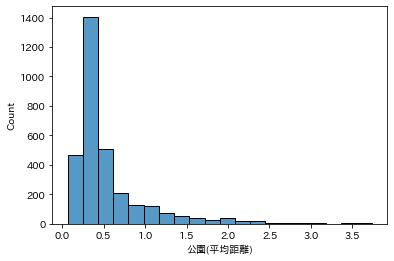

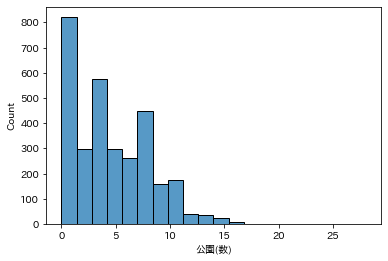

In [38]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [39]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

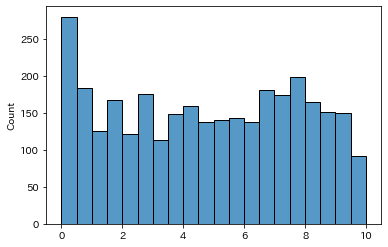

In [40]:
sns.histplot(_tmp_score, bins=20)
plt.show()

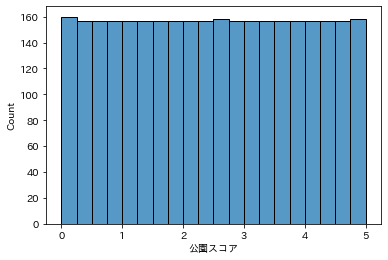

In [41]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [42]:
df_geo_master[score_name].describe()

count    3145.000000
mean        2.498409
std         1.444983
min         0.000000
25%         1.247613
50%         2.498409
75%         3.749204
max         5.000000
Name: 公園スコア, dtype: float64

In [43]:
df_geo_master[score_name] = df_geo_master[score_name].round(2)
df_geo_master['公園(平均距離)'] = df_geo_master['公園(平均距離)'].round(3)

## 保存

In [44]:
df_geo_master[
    ['town_id'] + all_feature_list + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False, encoding='utf-8_sig')

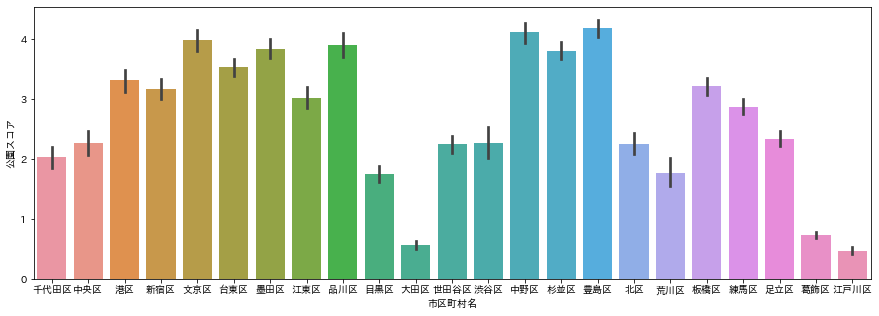

In [45]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_geo_master)
plt.show()

In [46]:
def get_score_top(df_data, target):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    feature_cols = [col for col in all_feature_list if col.startswith(target)]
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + feature_cols + [score_name]
    ].reset_index(drop=True)
    return df_level

In [47]:
df_level = get_score_top(df_geo_master, '公園')
print(df_level.shape)
df_level.head(10)

(901, 6)


,市区町村名,町名,町丁目,公園(平均距離),公園(数),公園スコア
0,品川区,東品川,東品川２丁目,0.140,16,5.00
1,品川区,旗の台,旗の台３丁目,0.085,16,5.00
2,港区,白金,白金１丁目,0.138,15,4.99
3,品川区,豊町,豊町１丁目,0.148,15,4.99
4,中野区,南台,南台３丁目,0.158,16,4.99
5,世田谷区,太子堂,太子堂２丁目,0.111,13,4.99
6,品川区,戸越,戸越２丁目,0.167,15,4.99
7,世田谷区,祖師谷,祖師谷５丁目,0.166,16,4.99
8,品川区,荏原,荏原１丁目,0.129,13,4.98
9,品川区,西中延,西中延３丁目,0.168,14,4.98


In [48]:
df_level.tail(10)

,市区町村名,町名,町丁目,公園(平均距離),公園(数),公園スコア
891,大田区,西六郷,西六郷１丁目,2.430,0,0.07
892,大田区,西糀谷,西糀谷２丁目,2.359,0,0.07
893,大田区,南蒲田,南蒲田１丁目,2.439,0,0.06
894,大田区,羽田,羽田４丁目,2.739,0,0.05
895,大田区,仲六郷,仲六郷１丁目,2.592,0,0.05
896,大田区,東六郷,東六郷１丁目,2.780,0,0.04
897,大田区,南六郷,南六郷１丁目,3.359,0,0.02
898,大田区,本羽田,本羽田３丁目,3.412,0,0.02
899,大田区,ふるさとの浜辺公園,ふるさとの浜辺公園,3.735,0,0.00
900,大田区,羽田沖水面,羽田沖水面,3.735,0,0.00
